## **05-2 교차 검증과 그리드 서치**

지금까지 우리는 전체 데이터를 훈련데이터와 테스트데이터로 나눈 다음, 훈련데이터로 훈련시킨 모델의 성능을 테스트데이터로 점검했다. 동일한 훈련데이터와 테스트데이터를 가지고 그런 과정을 반복하면 좋은 모델을 만들 수 있을까?

교재 242쪽을 잘 읽어보고 테스트 데이터세트의 역할을 다시 생각해보자.

### 1) 검증 세트

여러 가지 `max_depth` 값을 바꿔가면서 test data에서 정확도가 높은 결정트리 모델을 찾는다고 하자(이런 방법은 test data를 모델 훈련에 이용하는 것과 마찬가지다). 그 결과 test data에서는 성능이 좋은 모델을 찾을 수 있을지 모른다. 하지만 그 모델이 또다른 데이터에서도 그정도 성능을 발휘할까?

<u>모델의 성능을 높이기 위해 동일한 테스트데이터를 반복해서 사용하지말고 훈련데이터세트에서 **검증 데이터세트(validation dataset)**를 따로 만들어서 매개변수를 바꿔가며 모델을 평가할 수 있다.</u>

<u>그런 과정을 거쳐 좋은 모델을 찾은 다음, 마지막에 테스트세트를 가지고 모델의 일반화 성능을 최종 평가한다.   </u>

교재 243쪽 그림과 설명을 보라.

만약 전체 데이터를 8:2의 비율로 train-test set으로 나누었다면 그 80%의 훈련데이터에서 다시 일정 비율의 데이터를 검증데이터로 분리할 수 있다. 물론 비율은 적절히 조절하면 된다.

와인 데이터로 연습해보자.

In [60]:
import pandas as pd

wine = pd.read_csv('https://bit.ly/wine_csv_data')
wine

,alcohol,sugar,pH,class
0,9.4,1.9,3.51,0.0
1,9.8,2.6,3.20,0.0
2,9.8,2.3,3.26,0.0
3,9.8,1.9,3.16,0.0
4,9.4,1.9,3.51,0.0
...,...,...,...,...
6492,11.2,1.6,3.27,1.0
6493,9.6,8.0,3.15,1.0
6494,9.4,1.2,2.99,1.0
6495,12.8,1.1,3.34,1.0


In [61]:
data = wine.iloc[:,0:3].to_numpy()
target = wine.iloc[:,3].to_numpy()

In [62]:
from sklearn.model_selection import train_test_split

train, test, target1, target2 = train_test_split(data, target, random_state=0,stratify=target)

In [63]:
print(train.shape, test.shape)

(4872, 3) (1625, 3)


전체(6497개)의 80%에 해당하는 train 데이터(5197개) 가운데 20%를 검증데이터로 이용하자.

In [64]:
from sklearn.model_selection import train_test_split

train, val, target1, target3 = train_test_split(train, target1, random_state=0,stratify=target1)

In [65]:
print(train.shape, test.shape,val.shape)

(3654, 3) (1625, 3) (1218, 3)


`val_input, val_target`의 비율 20%는 6497개 전체 데이터의 20%가 아니고 train data(5197개) 가운데 20%다.

이제 `train, target1` 데이터로 모델을 훈련하고 `val, target3` 데이터로 모델의 성능을 검증하자.

In [66]:
from sklearn.tree import DecisionTreeClassifier

m=DecisionTreeClassifier(random_state=0)
m.fit(train,target1)

print(m.score(train,target1))
print(m.score(val,target3))

0.9969896004378763
0.854679802955665


과대적합이 생겼다. 교차검증에 대해 공부한 다음 더 좋은 트리모델을 찾아보자.

### 2) 교차 검증 (cross validation)

'교차검증'에 대한 245쪽 설명과 그림을 잘 살펴보자.

그림은 <u>**3-fold CV**를 설명하는 그림인데 훈련 데이터세트를 세 부분으로 나누어서 그 중 하나를 검증 세트로 이용하는 과정을 세 번 반복한 다음, 세 개의 검증 점수를 평균해서 최종 검증 점수를 얻는 방법</u>이다.

즉 교차검증은 반복마다 훈련, 검증 데이터가 바뀌므로 앞에서 살펴본 모델 훈련-검증과정보다 더 많은 다양한 데이터로 훈련하고 검증할 수 있는 방법이다.

사이킷런이 제공하는 교차검증 함수는 `model_selection` 모듈 안에 있는 `cross_validate()`다. 이 함수에는 모델 객체와 훈련 데이터를 입력하면 되기 때문에 사용자가 직접 검증 데이터를 만들 필요가 없다.

아래 결과에서 볼 수 있듯이 `cross_validate()` 함수는 기본적으로 5-fold CV를 수행하고 검증 점수(`test_score`)를 알려준다.

In [67]:
from sklearn.model_selection import cross_validate

cv=cross_validate(m,train,target1)
cv

{'fit_time': array([0.00773311, 0.00635266, 0.00667572, 0.00643563, 0.00670719]),
 'score_time': array([0.00123191, 0.00113392, 0.00120902, 0.00122046, 0.00112963]),
 'test_score': array([0.84404925, 0.86320109, 0.84131327, 0.86046512, 0.84794521])}

In [68]:
import numpy as np

np.mean(cv['test_score'])

0.851394786649926

In [69]:
from sklearn.model_selection import cross_validate

cv = cross_validate(m, train, target1, return_train_score = True)

np.mean(cv['train_score'])

0.9974001187805757

기본값 5-fold cv 대신 3-fold cv로 바꾸고 싶다면,

In [70]:
from sklearn.model_selection import cross_validate

cv = cross_validate(m, train, target1, return_train_score = True,cv=3)

print(np.mean(cv['train_score']),np.mean(cv['test_score']))

0.9976737821565408 0.8500273672687465


* 복습 퀴즈 : wine 데이터로 만든 train 데이터(전체의 70%)를 이용해서 `max_depth` 3인 tree 분류 모델에 대해 7-fold 교차검증을 실시하시오. 결과로부터  훈련데이터와 검증데이터에서의 검증점수를 각각 구하시오.

In [71]:
import pandas as pd

wine = pd.read_csv('https://bit.ly/wine_csv_data')

In [72]:
data = wine.iloc[:,0:3].to_numpy()
target = wine.iloc[:,3].to_numpy()

In [73]:
from sklearn.model_selection import train_test_split

train, test, target1, target2 = train_test_split(data, target, random_state=0,stratify=target)

In [74]:
from sklearn.tree import DecisionTreeClassifier

m = DecisionTreeClassifier(max_depth = 3, random_state=0)

In [75]:
from sklearn.model_selection import cross_validate

cv7 = cross_validate(m, train, target1, cv = 7, return_train_score = True)

print(np.mean(cv7['train_score']),np.mean(cv7['test_score']))

0.8438013136288999 0.8419540229885059


### 3) 하이퍼파라미터 튜닝

* model parameter와 hyper parameter (p. 248)

  먼저 [사이킷런 도움말](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)을 통해 결정트리 분류모델의 하이퍼파라미터들에는 어떤 것이 있는지 알아보자.
  `max_depth, min_samples_split, min_samples_leaf, min_impurity_decrease` 등 여러가지다. 우리는 이런 여러 하이퍼파라미터의 최적값 조합을 찾아야한다. 각각이 아니라 **동시에** 여러 파라미터의 최적값을 찾는 방법인 '그리드 서치(grid search)'를 설명하는 248쪽 본문 설명을 잘 읽어보자.

* grid search : 여러 하이퍼파라미터의 값을 **동시에 바꿔가며** 최적 파라미터를 찾는 방법.

  사이킷런의 `model_selection` 모듈에 있는 `GridSearchCV()`를 이용하면 <u>하이퍼파라미터 탐색과 교차 검증을 한꺼번에</u> 할 수 있다. ([도움말](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html))


  보기) 먼저 여러 하이퍼파라미터의 최적값을 찾기 전에 `GridSearchCV`를 이용해서 단일한 하이퍼파라미터의 최적값을 찾는 과정부터 연습하자.

  찾을 파라미터는 앞절의 확인문제(241쪽)에서 공부한 트리모델의 최적 `min_impurity_decrease`(노드 분할에 필요한 불순도 감소 최소값을 나타내는 파라미터)다.

다시 8:2로 나눈 데이터로 돌아가서 연습하자.

In [17]:
import pandas as pd

wine = pd.read_csv('https://bit.ly/wine_csv_data')

In [18]:
data = wine.iloc[:,0:3].to_numpy()
target = wine.iloc[:,3].to_numpy()

In [19]:
from sklearn.model_selection import train_test_split

train, test, target1, target2 = train_test_split(data, target, random_state=0,stratify=target)

먼저 <u>파라미터 값들이 들어있는 리스트를 딕셔너리로 만든다.</u>

cv 의 기본값이 5이므로 4 개 `min_impurity_decrease` 파라미터 값 각각에 대해 다섯번씩 즉 총 20회 교차검증한다. 각 파라미터 값에서는 5개의 test_score를 구하여 평균을 내서 그 파라미터에서 모델의 성능을 알아본다. 파라미터 비교는 4개의 mean_test_score값을 비교하여 그 값이 가장 큰 값을 최적 파라미터로 선택한다.

파라미터 수가 늘어나면 계산량도 많아지므로 속도를 높이기 위해 `n_jobs = -1`이라고 지정하여 시스템의 모든 CPU core를 이용한다.

In [76]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

p = {'min_impurity_decrease': [0.0001, 0.0002, 0.0003, 0.0004 ,0.0005]}

m=DecisionTreeClassifier(random_state=0)

gs = GridSearchCV(m, p, n_jobs = -1)
gs.fit(train, target1)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'min_impurity_decrease': [0.0001, 0.0002, 0.0003,
                                                   0.0004, 0.0005]})

20개 모델 가운데에서 찾은 최적 모델은 `gs.best_estimator_` 속성에 들어있으므로 이 모델을 249쪽 설명과 같이 보통 결정 트리 모델처럼 이용하면 된다.

In [77]:
gs.best_params_

{'min_impurity_decrease': 0.0003}

In [78]:
bm = gs.best_estimator_

print(bm.score(train, target1),bm.score(test, target2))

0.916256157635468 0.8553846153846154


각 매개변수에서 수행한 교차검증 평균 점수를 비롯한 많은 결과들은 `cv_results_`라는 딕셔너리에 들어있다.

In [24]:
gs.cv_results_

{'mean_fit_time': array([0.0101068 , 0.00956907, 0.00920258, 0.01188135, 0.0086    ]),
 'std_fit_time': array([0.00064669, 0.00079703, 0.00053448, 0.00614409, 0.00115702]),
 'mean_score_time': array([0.00188193, 0.00173831, 0.00178652, 0.00337658, 0.00165548]),
 'std_score_time': array([1.30031718e-04, 9.31391265e-05, 9.36164327e-05, 1.64398031e-03,
        2.19404720e-04]),
 'param_min_impurity_decrease': masked_array(data=[0.0001, 0.0002, 0.0003, 0.0004, 0.0005],
              mask=[False, False, False, False, False],
        fill_value=1e+20),
 'params': [{'min_impurity_decrease': 0.0001},
  {'min_impurity_decrease': 0.0002},
  {'min_impurity_decrease': 0.0003},
  {'min_impurity_decrease': 0.0004},
  {'min_impurity_decrease': 0.0005}],
 'split0_test_score': array([0.87692308, 0.88      , 0.87179487, 0.86871795, 0.86871795]),
 'split1_test_score': array([0.87282051, 0.87384615, 0.86564103, 0.86871795, 0.86871795]),
 'split2_test_score': array([0.89425051, 0.87782341, 0.88603696, 0.88

딕셔너리를 pandas 데이터프레임으로 바꾸면 더 보기 쉽다.

In [79]:
pd.DataFrame(gs.cv_results_).T

,0,1,2,3,4
mean_fit_time,0.011907,0.009519,0.009197,0.008555,0.007439
std_fit_time,0.00124,0.000405,0.000431,0.000259,0.000997
mean_score_time,0.002049,0.002111,0.001944,0.00212,0.001911
std_score_time,0.000168,0.000049,0.000127,0.000139,0.000417
param_min_impurity_decrease,0.0001,0.0002,0.0003,0.0004,0.0005
params,{'min_impurity_decrease': 0.0001},{'min_impurity_decrease': 0.0002},{'min_impurity_decrease': 0.0003},{'min_impurity_decrease': 0.0004},{'min_impurity_decrease': 0.0005}
split0_test_score,0.876923,0.88,0.871795,0.868718,0.868718
split1_test_score,0.872821,0.873846,0.865641,0.868718,0.868718
split2_test_score,0.894251,0.877823,0.886037,0.882957,0.879877
split3_test_score,0.867556,0.87269,0.877823,0.871663,0.86653


교차검증 평균 점수만 보려면 딕셔너리의 키를 이용해서 아래와 같이 확인할 수 있다.

In [85]:
gs.cv_results_['mean_test_score']

array([0.75389984, 0.81034483, 0.83825944, 0.84811166, 0.85816913,
       0.86165846, 0.85734811, 0.8546798 , 0.85714286, 0.85714286,
       0.8569376 , 0.85385878])

3번째 파라미터가 가장 좋다.

In [27]:
np.argmax(gs.cv_results_['mean_test_score'])

2

* 퀴즈 : 나무 모델의 `max_depth`를 7부터 12까지 여섯 값에서 선택하려 한다. `GridSearchCV`를 이용해서 각 파라미터마다 3회씩 교차검증해보라. 그 결과로부터 최적 파라미터와 최적 모델을 찾고 그 모델의 mean test score값을 구해보라.

In [81]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

p = {'max_depth': range(1, 13)}

m = DecisionTreeClassifier(random_state = 0)

gs = GridSearchCV(m, p, n_jobs = -1, cv = 3)
gs.fit(train, target1)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': range(1, 13)})

In [82]:
gs.best_params_

{'max_depth': 6}

In [83]:
bm=gs.best_estimator_

print(bm.score(train, target1),bm.score(test, target2))

0.8782840722495895 0.8535384615384616


In [84]:
pd.DataFrame(gs.cv_results_).T

,0,1,2,3,4,5,6,7,8,9,10,11
mean_fit_time,0.003855,0.004434,0.005395,0.00668,0.007909,0.007192,0.008074,0.009018,0.008816,0.010635,0.010142,0.009345
std_fit_time,0.000195,0.000123,0.00035,0.000667,0.00108,0.000065,0.000234,0.000846,0.00017,0.001561,0.00006,0.001618
mean_score_time,0.001797,0.001732,0.001822,0.001952,0.001986,0.00195,0.002129,0.001895,0.001978,0.002011,0.002445,0.002138
std_score_time,0.000279,0.000074,0.000129,0.000028,0.000231,0.000137,0.000287,0.000036,0.000053,0.000049,0.000556,0.000643
param_max_depth,1,2,3,4,5,6,7,8,9,10,11,12
params,{'max_depth': 1},{'max_depth': 2},{'max_depth': 3},{'max_depth': 4},{'max_depth': 5},{'max_depth': 6},{'max_depth': 7},{'max_depth': 8},{'max_depth': 9},{'max_depth': 10},{'max_depth': 11},{'max_depth': 12}
split0_test_score,0.753695,0.811576,0.840517,0.852217,0.851601,0.860837,0.850985,0.85899,0.85468,0.862069,0.860222,0.858374
split1_test_score,0.753695,0.807882,0.843596,0.852833,0.860222,0.862069,0.863916,0.851601,0.8633,0.855296,0.8633,0.855911
split2_test_score,0.75431,0.811576,0.830665,0.839286,0.862685,0.862069,0.857143,0.853448,0.853448,0.854064,0.847291,0.847291
mean_test_score,0.7539,0.810345,0.838259,0.848112,0.858169,0.861658,0.857348,0.85468,0.857143,0.857143,0.856938,0.853859


In [88]:
np.max(gs.cv_results_['mean_test_score'])

0.8616584564860427

In [89]:
np.argmax(gs.cv_results_['mean_test_score'])

5

In [90]:
pd.DataFrame(gs.cv_results_).T[5]

,5
mean_fit_time,0.007192
std_fit_time,0.000065
mean_score_time,0.00195
std_score_time,0.000137
param_max_depth,6
params,{'max_depth': 6}
split0_test_score,0.860837
split1_test_score,0.862069
split2_test_score,0.862069
mean_test_score,0.861658


이제 `GridSearchCV()`를 이용해서 세 파라미터(`min_impurity_decrease`, `max_depth`, `min_samples_split`)의 최적값 조합을 찾아보자.

비교할 파라미터의 수는 `min_impurity_decrease`는 9개, `max_depth`는 15개, `min_samples_split`는 10개다.

세 파라미터를 조합하면 총 $9 \times 15 \times 10 = 1,350$개의 파라미터 조합이 생긴다. 각 조합마다 5회씩 교차검증이 이루어지므로 총 교차검증 수는 $1,350 \times 5 = 6,750$ 회가 된다 (아래 코드를 실행하면 약 30초~ 1분 정도 걸린다. `n_jobs=-1`가 없을 때의 실행시간과 비교해보라).

In [91]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

p = {'min_impurity_decrease': np.arange(0.0001, 0.001, 0.0001),
          'max_depth': range(2, 20, 1),
          'min_samples_split': range(2, 100, 10)
          }
m = DecisionTreeClassifier(random_state = 0)

gs = GridSearchCV(m, p, n_jobs=-1)
gs.fit(train, target1)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': range(2, 20),
                         'min_impurity_decrease': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009]),
                         'min_samples_split': range(2, 100, 10)})

In [92]:
gs.best_params_

{'max_depth': 13,
 'min_impurity_decrease': 0.00030000000000000003,
 'min_samples_split': 2}

In [93]:
bm=gs.best_estimator_

print(bm.score(train, target1),bm.score(test, target2))

0.9154351395730707 0.856


In [94]:
pd.DataFrame(gs.cv_results_).T

,0,1,2,3,4,5,6,7,8,9,...,1610,1611,1612,1613,1614,1615,1616,1617,1618,1619
mean_fit_time,0.004913,0.005673,0.004799,0.006461,0.006502,0.005338,0.004745,0.004705,0.004795,0.004976,...,0.007167,0.007009,0.007287,0.007115,0.010585,0.006977,0.007521,0.007328,0.007155,0.006879
std_fit_time,0.000204,0.001178,0.000217,0.002409,0.002014,0.001134,0.000123,0.000135,0.000231,0.000264,...,0.000264,0.000149,0.00029,0.000204,0.004112,0.000207,0.000892,0.000485,0.000376,0.000395
mean_score_time,0.001734,0.00207,0.002061,0.00349,0.003429,0.001681,0.001649,0.001711,0.002971,0.001731,...,0.001646,0.001719,0.001658,0.001681,0.002653,0.00171,0.001777,0.00186,0.001761,0.00164
std_score_time,0.000097,0.000603,0.000716,0.002891,0.002522,0.000107,0.00007,0.000249,0.002596,0.000166,...,0.00007,0.000119,0.000045,0.000069,0.001681,0.000067,0.000092,0.000122,0.000103,0.000186
param_max_depth,2,2,2,2,2,2,2,2,2,2,...,19,19,19,19,19,19,19,19,19,19
param_min_impurity_decrease,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,...,0.0009,0.0009,0.0009,0.0009,0.0009,0.0009,0.0009,0.0009,0.0009,0.0009
param_min_samples_split,2,12,22,32,42,52,62,72,82,92,...,2,12,22,32,42,52,62,72,82,92
params,"{'max_depth': 2, 'min_impurity_decrease': 0.00...","{'max_depth': 2, 'min_impurity_decrease': 0.00...","{'max_depth': 2, 'min_impurity_decrease': 0.00...","{'max_depth': 2, 'min_impurity_decrease': 0.00...","{'max_depth': 2, 'min_impurity_decrease': 0.00...","{'max_depth': 2, 'min_impurity_decrease': 0.00...","{'max_depth': 2, 'min_impurity_decrease': 0.00...","{'max_depth': 2, 'min_impurity_decrease': 0.00...","{'max_depth': 2, 'min_impurity_decrease': 0.00...","{'max_depth': 2, 'min_impurity_decrease': 0.00...",...,"{'max_depth': 19, 'min_impurity_decrease': 0.0...","{'max_depth': 19, 'min_impurity_decrease': 0.0...","{'max_depth': 19, 'min_impurity_decrease': 0.0...","{'max_depth': 19, 'min_impurity_decrease': 0.0...","{'max_depth': 19, 'min_impurity_decrease': 0.0...","{'max_depth': 19, 'min_impurity_decrease': 0.0...","{'max_depth': 19, 'min_impurity_decrease': 0.0...","{'max_depth': 19, 'min_impurity_decrease': 0.0...","{'max_depth': 19, 'min_impurity_decrease': 0.0...","{'max_depth': 19, 'min_impurity_decrease': 0.0..."
split0_test_score,0.810256,0.810256,0.810256,0.810256,0.810256,0.810256,0.810256,0.810256,0.810256,0.810256,...,0.86359,0.86359,0.86359,0.864615,0.857436,0.855385,0.855385,0.855385,0.855385,0.855385
split1_test_score,0.818462,0.818462,0.818462,0.818462,0.818462,0.818462,0.818462,0.818462,0.818462,0.818462,...,0.871795,0.871795,0.871795,0.871795,0.873846,0.873846,0.876923,0.876923,0.876923,0.876923


최적 파라미터 조합에서의 교차검증 평균점수는 아래와 같다.

In [95]:
np.max(gs.cv_results_['mean_test_score'])

0.8741810140578107

In [96]:
np.argmax(gs.cv_results_['mean_test_score'])

1010

In [97]:
pd.DataFrame(gs.cv_results_).T[1010]

,1010
mean_fit_time,0.009597
std_fit_time,0.002463
mean_score_time,0.001862
std_score_time,0.000243
param_max_depth,13
param_min_impurity_decrease,0.0003
param_min_samples_split,2
params,"{'max_depth': 13, 'min_impurity_decrease': 0.0..."
split0_test_score,0.871795
split1_test_score,0.866667


### 4) 랜덤 서치


비교할 파라미터의 값들을 정하는 대신 파라미터 값의 확률분포를 지정하고 랜덤하게 파라미터를 샘플링하여 비교하도록 만들 수 있다. 교재를 따라 Scipy 패키지의 `stats` 모듈에 들어있는 `uniform, randint`를 이용하여 균등분포로부터 파라미터를 샘플링해보자.

  - `uniform(a, b)`는 $(a, b)$ 사이의 실수값을,

  - `randint(a, b)`는 정수 'a'와 'b' 사이의 정수값('b`는 포함되지 않고 'b-1'까지 나온다)을

  갖는 균등분포를 뜻한다.

즉 `uniform()`은 연속형 균등분포, `randint()`는 이산형 균등분포를 의미한다.

In [98]:
import pandas as pd

wine = pd.read_csv('https://bit.ly/wine_csv_data')

In [99]:
data = wine.iloc[:,0:3].to_numpy()
target = wine.iloc[:,3].to_numpy()

In [100]:
from sklearn.model_selection import train_test_split

train, test, target1, target2 = train_test_split(data, target, random_state=0,stratify=target)

가령 0과 10 사이의 정수 10개를 랜덤하게 샘플링하려면 아래와 같이 하면 된다.

In [37]:
from scipy.stats import uniform, randint

s = randint(0, 10)
s.rvs(size = 10)

array([4, 8, 2, 2, 3, 7, 4, 0, 7, 3])

0과 10 사이의 정수 1,000개를 랜덤하게 샘플링한 다음 각 숫자의 빈도를 보려면,

In [38]:
np.unique(s.rvs(1000), return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 89, 100, 112, 105, 111,  89, 109,  75,  96, 114]))

`uniform(0, 1)` 분포에서 10개를 랜덤하게 샘플링해보자.

In [39]:
from scipy.stats import uniform, randint

u = uniform(0, 1)
u.rvs(10)

array([0.01915957, 0.31665481, 0.17993026, 0.4723207 , 0.81502237,
       0.06841352, 0.94810223, 0.27421981, 0.72421524, 0.57220704])

이제 앞에서 살펴본 세 파라미터(`min_impurity_decrease, max_depth, min_samples_split`)에 `min_samples_leaf`까지 추가해서 4개 파라미터의 최적 조합을 찾아보자.

랜덤 샘플링 횟수를 100회(`n_iter=100`, 교차 검증 수를 지정하는 `cv`의 기본값이 5이므로 총 500회 교차검증)로 지정하여 아래 코드를 실행하여 6,750회 교차검증했을 때와 실행시간을 비교해보자.

In [101]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

p = {'min_impurity_decrease': uniform(0.0001, 0.001),
          'max_depth': randint(10,40),
          'min_samples_split': randint(2, 40),
          'min_samples_leaf': randint(1, 50),
          }

m = DecisionTreeClassifier(random_state = 0)

rs = RandomizedSearchCV(m, p, n_jobs=-1, random_state=0, n_iter=100)
rs.fit(train, target1)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=0), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c2f0cf6c5b0>,
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7c2f0cd8c1f0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c2f0cd5ea40>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c2f0d795f00>},
                   random_state=0)

In [102]:
rs.best_params_

{'max_depth': 18,
 'min_impurity_decrease': 0.00037354203481563576,
 'min_samples_leaf': 14,
 'min_samples_split': 19}

교차검증 결과 가운데 가장 높은 점수는

In [107]:
np.max(rs.cv_results_['mean_test_score'])

0.8749994208392566

In [108]:
np.argmax(rs.cv_results_['mean_test_score'])

75

In [109]:
pd.DataFrame(rs.cv_results_).T[75]

,75
mean_fit_time,0.012375
std_fit_time,0.01012
mean_score_time,0.001785
std_score_time,0.000125
param_max_depth,18
param_min_impurity_decrease,0.000374
param_min_samples_leaf,14
param_min_samples_split,19
params,"{'max_depth': 18, 'min_impurity_decrease': 0.0..."
split0_test_score,0.873846


선택한 파라미터 조합으로 만든 최종 모델의 성능은

In [110]:
bm = rs.best_estimator_

print(bm.score(train, target1),bm.score(test, target2))

0.8942939244663383 0.8535384615384616


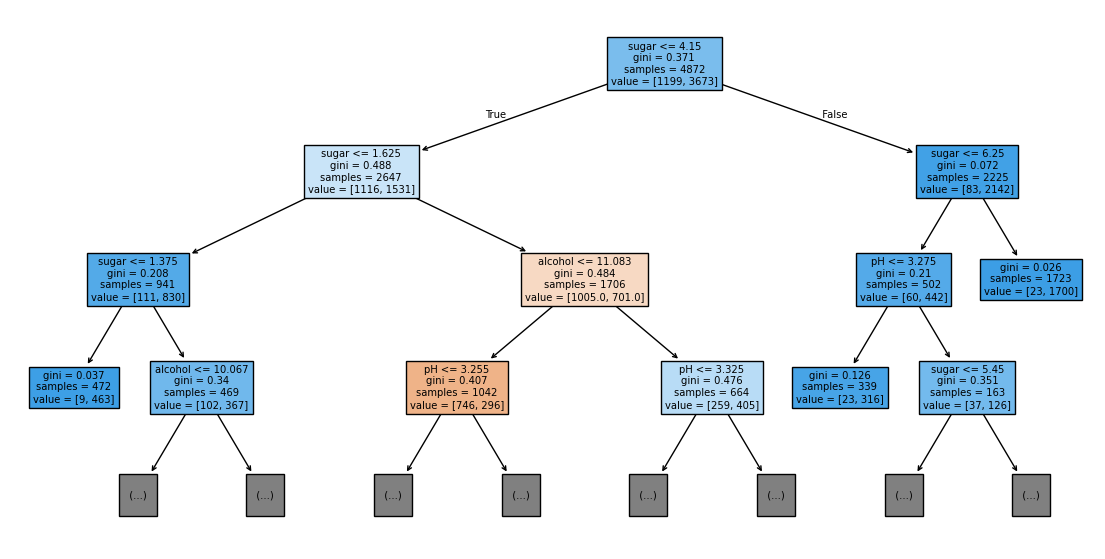

In [111]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(14,7))
plot_tree(bm, max_depth = 3, filled=True, feature_names=['alcohol', 'sugar', 'pH'])
plt.show()

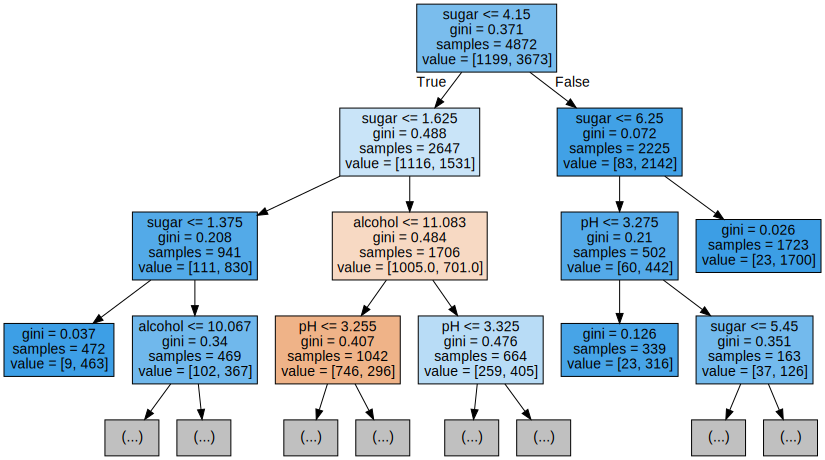

In [112]:
import graphviz
from sklearn import tree

dot_data = tree.export_graphviz(bm, filled = True, max_depth = 3, feature_names=['alcohol', 'sugar', 'pH'])
graphviz.Source(dot_data)

## 확인문제

`splitter='random'` 옵션을 추가한 결정트리분류

In [49]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

p = {'min_impurity_decrease': uniform(0.0001, 0.001),
          'max_depth': randint(10,40),
          'min_samples_split': randint(2, 40),
          'min_samples_leaf': randint(1, 50),
          }

m = DecisionTreeClassifier(random_state = 0,splitter='random')

rs = RandomizedSearchCV(m, p, n_jobs=-1, random_state=0, n_iter=100)
rs.fit(train, target1)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=0,
                                                    splitter='random'),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c2f241ebbb0>,
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7c2f251a3df0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c2f251a1180>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c2f241ebe50>},
                   random_state=0)

In [50]:
rs.best_params_

{'max_depth': 39,
 'min_impurity_decrease': 0.0003123904988903086,
 'min_samples_leaf': 3,
 'min_samples_split': 7}

In [51]:
np.max(rs.cv_results_['mean_test_score'])

0.8665849523508662

In [52]:
np.argmax(rs.cv_results_['mean_test_score'])

64

In [55]:
pd.DataFrame(rs.cv_results_).T[64]

,64
mean_fit_time,0.012121
std_fit_time,0.003083
mean_score_time,0.002742
std_score_time,0.00123
param_max_depth,39
param_min_impurity_decrease,0.000312
param_min_samples_leaf,3
param_min_samples_split,7
params,"{'max_depth': 39, 'min_impurity_decrease': 0.0..."
split0_test_score,0.868718


In [54]:
bm = rs.best_estimator_

print(bm.score(train, target1),bm.score(test, target2))

0.8747947454844006 0.8492307692307692


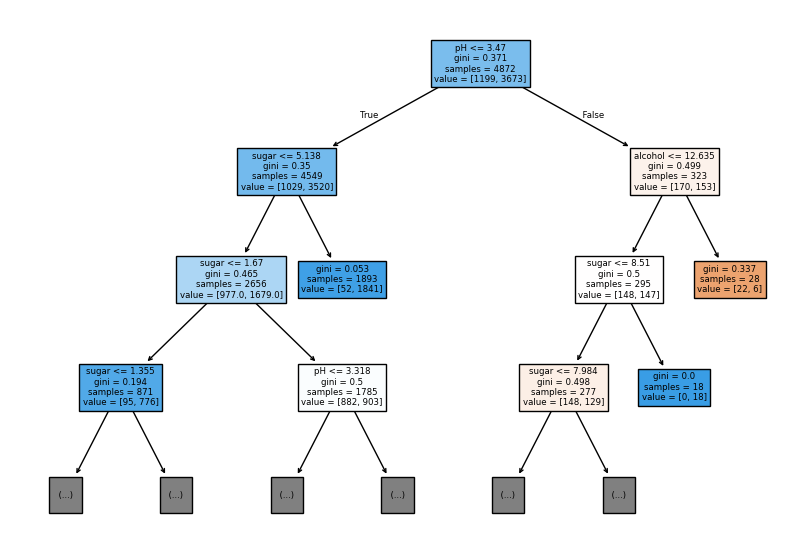

In [56]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(10,7))
plot_tree(bm, max_depth = 3, filled=True, feature_names=['alcohol', 'sugar', 'pH'])
plt.show()

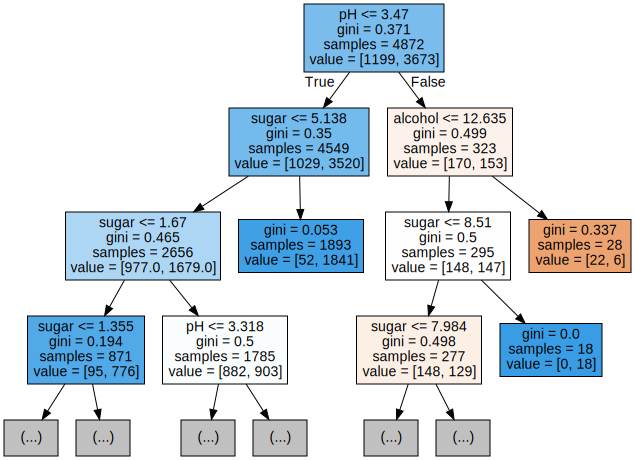

In [58]:
import graphviz
from sklearn import tree

dot_data = tree.export_graphviz(bm, filled = True, max_depth = 3, feature_names=['alcohol', 'sugar', 'pH'])
graphviz.Source(dot_data)